# LeNet 5

Author: Franco Hernández Victor Alfonso

<a href="https://colab.research.google.com/github/VictorFranco/python-lenet-from-scratch/blob/main/LeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0],[1])
])

dataset = datasets.MNIST(
    "MNIST_data",
    transform = transform,
    download = True
)

trainset = torch.utils.data.Subset(dataset, list(range(1000)))
testset = torch.utils.data.Subset(dataset, list(range(1000, 2000)))

100%|██████████| 9912422/9912422 [00:00<00:00, 106605754.55it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60841634.27it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 38904904.24it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11056604.04it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [2]:
class LinearLayer():
  in_features = 0
  out_features = 0
  weights = np.array([])
  biases = np.array([])
  def __init__(self, in_features, out_features):
    self.in_features = in_features
    self.out_features = out_features
    self.weights = np.random.uniform(-0.5, 0.5, size=(in_features, out_features))
    self.biases = np.random.uniform(-0.5, 0.5, size=(1, out_features))
  def forward(self, input):
    return input @ self.weights + self.biases

In [3]:
class ConvolutionalLayer():
  kernels = np.array([])
  biases = np.array([])
  def __init__(self, in_channels, out_channels, kernel_size):
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.kernels = np.random.uniform(-0.5, 0.5, size=(out_channels, in_channels, kernel_size, kernel_size))
    self.biases = np.random.uniform(-0.5, 0.5, size=(1, out_channels))
  def forward(self, image):
    if image.ndim == 2:
      image = np.expand_dims(image, axis=0)
    maps = np.zeros((self.kernels.shape[0], image.shape[1]-4, image.shape[1]-4))
    for i in range(self.out_channels):
      kernel = self.kernels[i]
      bias = self.biases[0,i]
      feature_map = []
      for j in range(image.shape[1]-4):
        row = []
        for k in range(image.shape[1]-4):
          window = image[:,j:5+j,k:5+k]
          maps[i,j,k] = (kernel * window).sum() + bias
    return maps

In [4]:
def max_pooling(window_size, stride, i_input):
  pool = np.zeros((i_input.shape[0],int(i_input.shape[1]/2),int(i_input.shape[1]/2)))
  for i in range(i_input.shape[0]):
    for j in range(int(i_input.shape[1]/2)):
      for k in range(int(i_input.shape[1]/2)):
        pool[i,j,k] = i_input[i,j*2:2+j*2,k*2:2+k*2].max()
  return pool
def softmax(matrix):
  return np.exp(matrix) / np.exp(matrix).sum()
def tanh_prime(logit):
  return 1 - np.tanh(logit)**2
def dataset2numpy(dataset):
  result = []
  for [img, label] in dataset:
    img = img[0].numpy()
    result.append([img, label])
  return result

trainset, testset = dataset2numpy(trainset), dataset2numpy(testset)

In [5]:
class LeNet5():
  trainset = np.array([])
  testset = np.array([])
  def __init__(self, trainset, testset):
    self.trainset = trainset
    self.testset = testset
    self.architecture = [
        ConvolutionalLayer(1, 6, 5),
        "tanh",
        "maxpool",
        ConvolutionalLayer(6, 16, 5),
        "tanh",
        "maxpool",
        "flatten",
        LinearLayer(400, 120),
        "tanh",
        LinearLayer(120, 84),
        "tanh",
        LinearLayer(84, 10),
        "softmax"
    ]
  def forwardpass(self, x):
    self.conv_imgs = []
    for elm in self.architecture:
      match elm:
        case "tanh":
          x = np.tanh(x)
          self.conv_imgs.append(x)
        case "softmax":
          x = softmax(x)
        case "maxpool":
          x = max_pooling(2, 2, x)
          self.conv_imgs.append(x)
        case "flatten":
          x = np.expand_dims(x.flatten(), axis=0)
        case _: # conv layer or linear layer
          x = elm.forward(x)
    return x
  def train(self, lr, epochs, batch_size):
    for epoch in range(epochs):
      d_k, d_w, d_b = [], [], []
      for i in range(3):
        d_w.append(np.zeros_like(self.architecture[11-2*i].weights))
        d_b.append(np.zeros_like(self.architecture[11-2*i].biases))
      for i in range(2):
        d_k.append(np.zeros_like(self.architecture[3-3*i].kernels))
        d_b.append(np.zeros_like(self.architecture[3-3*i].biases))
      for current_batch in range(int(len(self.trainset)/batch_size)):
        train_batch = self.trainset[batch_size*current_batch:batch_size*(current_batch+1)]
        for [img, label] in train_batch:
          # forward
          c1 = self.architecture[0].forward(img)
          z1 = np.tanh(c1)
          p1 = max_pooling(2, 2, z1)
          c2 = self.architecture[3].forward(p1)
          z2 = np.tanh(c2)
          p2 = max_pooling(2, 2, z2)
          f = np.expand_dims(p2.flatten(), axis=0)
          h1 = self.architecture[7].forward(f)
          z3 = np.tanh(h1)
          h2 = self.architecture[9].forward(z3)
          z4 = np.tanh(h2)
          h3 = self.architecture[11].forward(z4)
          output = softmax(h3)
          # backpropagation
          # linear
          labels = np.zeros_like(output)
          labels[0][label-1] = 1 # label to onehot
          delta = labels - output
          d_w[0] += z4.T @ delta
          d_b[0] += delta
          delta = delta @ self.architecture[11].weights.T * tanh_prime(h2)
          d_w[1] += z3.T @ delta
          d_b[1] += delta
          delta = delta @ self.architecture[9].weights.T * tanh_prime(h1)
          d_w[2] += f.T @ delta
          d_b[2] += delta
          # convolutional
          delta = delta @ self.architecture[7].weights.T
          delta = np.reshape(delta, (16,5,5))
          for i in range(16):
            for j in range(6):
              for k in range(10):
                for l in range(10):
                  conv_delta = delta[i] * tanh_prime(c2[i,k,l])
                  d_k[0][i,j] += conv_delta * p1[j,k:k+5,l:l+5]
                  d_b[3][0,i] += conv_delta.sum()
                  conv_delta = conv_delta * self.architecture[3].kernels[i,j] * tanh_prime(c1[j,k,l])
                  d_k[1][j] += conv_delta * img[k:k+5,l:l+5]
                  d_b[4][0,j] += conv_delta.sum()
      for i in range(3):
        self.architecture[11-2*i].weights += lr / len(trainset) * d_w[i]
        self.architecture[11-2*i].biases += lr / len(trainset) * d_b[i]
      for i in range(2):
        self.architecture[3-3*i].kernels += lr / len(trainset) * d_k[i]
        self.architecture[3-3*i].biases += lr / len(trainset) * d_b[i+3]

In [6]:
# hyperparameters
np.random.seed(30)
lr = 0.01
epochs = 1
batch_size = 25

lenet = LeNet5(trainset, testset)
lenet.train(lr, epochs, batch_size)

[[0.00617481 0.05691285 0.08472473 0.11062439 0.40982087 0.12149254
  0.04174733 0.04605417 0.06012424 0.06232406]]
4


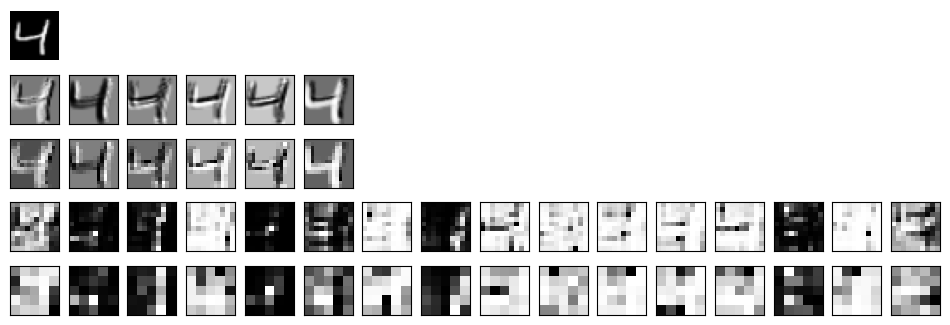

In [7]:
img = trainset[2][0]
outputs = lenet.forwardpass(img)
print(outputs)
print(np.argmax(outputs))

fig, ax = plt.subplots(nrows=5, ncols=16, figsize=(12, 4))
for i in range(16):
  for j in range(5):
    ax[j][i].axis("off")
ax[0][0].imshow(img,cmap='gray')
for i in range(4):
  for j in range(len(lenet.conv_imgs[i])):
    ax[i+1][j].axis("on")
    ax[i+1][j].set_xticks([])
    ax[i+1][j].set_yticks([])
    ax[i+1][j].imshow(lenet.conv_imgs[i][j],cmap='gray')